In [1]:
from portfolio_optimization.data_processing import *
from portfolio_optimization.data_collection import *
from datetime import datetime, timezone, timedelta
from tokens.get_assets import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import risk_models, plotting

High risk tickers: 15
Medium risk tickers: 60
Low risk tickers: 8
             aave         ada        avax           btc        cake  \
count  366.000000  366.000000  366.000000    366.000000  366.000000   
mean    74.563876    0.375466   16.793624  23045.674887    3.437858   
std     13.035935    0.072702    3.817511   4476.566956    1.026975   
min     50.084853    0.243946   10.856752  15758.291282    1.343584   
25%     63.787078    0.319734   13.720929  19414.949041    3.192130   
50%     74.911738    0.370236   16.784493  22854.081255    3.771447   
75%     83.169616    0.417566   18.405967  27199.891531    4.122209   
max    113.812053    0.570998   29.319863  31434.735470    4.929843   

              dot          eth        link       matic         sol  \
count  366.000000   366.000000  366.000000  366.000000  366.000000   
mean     6.093073  1601.048565    6.922394    0.926987   24.023886   
std      1.038307   248.977819    0.743366    0.176788    8.466857   
min      4.280

,aave,ada,avax,btc,cake,dot,eth,link,matic,sol,uni,bnb,wbtc
aave,1.000000,0.831262,0.921040,0.112163,0.516260,0.928708,0.298769,0.773349,0.420571,0.857674,0.874643,0.452020,0.113320
ada,0.831262,1.000000,0.906556,0.039678,0.474061,0.920719,0.241128,0.751273,0.229068,0.904443,0.733535,0.465077,0.041583
avax,0.921040,0.906556,1.000000,0.114438,0.479749,0.957965,0.314382,0.753800,0.395601,0.856174,0.859190,0.517018,0.115708
btc,0.112163,0.039678,0.114438,1.000000,-0.622959,0.011311,0.942378,0.038483,0.122059,0.046623,-0.148904,0.218594,0.999985
cake,0.516260,0.474061,0.479749,-0.622959,1.000000,0.577361,-0.512417,0.619844,0.432449,0.413624,0.644278,0.371269,-0.622090
dot,0.928708,0.920719,0.957965,0.011311,0.577361,1.000000,0.217210,0.802728,0.376431,0.867506,0.882436,0.480382,0.012608
eth,0.298769,0.241128,0.314382,0.942378,-0.512417,0.217210,1.000000,0.191978,0.196534,0.204436,0.027985,0.352563,0.942918
link,0.773349,0.751273,0.753800,0.038483,0.619844,0.802728,0.191978,1.000000,0.495094,0.671085,0.742738,0.654338,0.039586
matic,0.420571,0.229068,0.395601,0.122059,0.432449,0.376431,0.196534,0.495094,1.000000,0.038906,0.394868,0.736535,0.122530
sol,0.857674,0.904443,0.856174,0.046623,0.413624,0.867506,0.204436,0.671085,0.038906,1.000000,0.752547,0.238021,0.048394


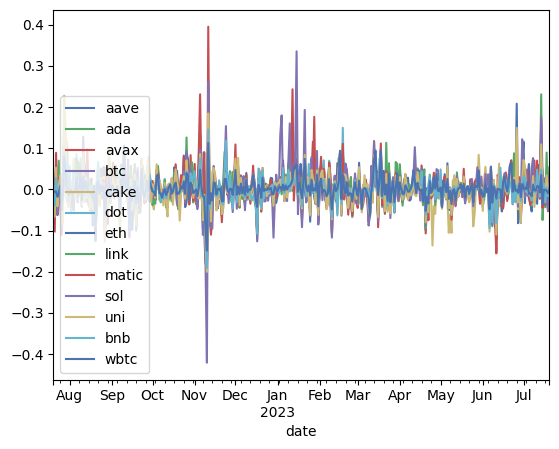

In [2]:
asset_list = get_tickers()
df = get_historical_prices_for_assets(asset_list['high_risk_tickers'], time_range=timedelta(days=365))
# Print comprehensive statistical summary
print(df.describe())

# this will give you the percentage change
df_percentage_variation = df.pct_change()

# plot variation of each asset's price
df_percentage_variation.plot()
pd.DataFrame(df).corr()

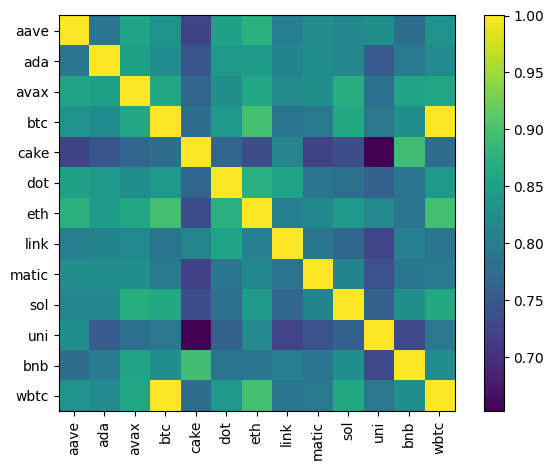

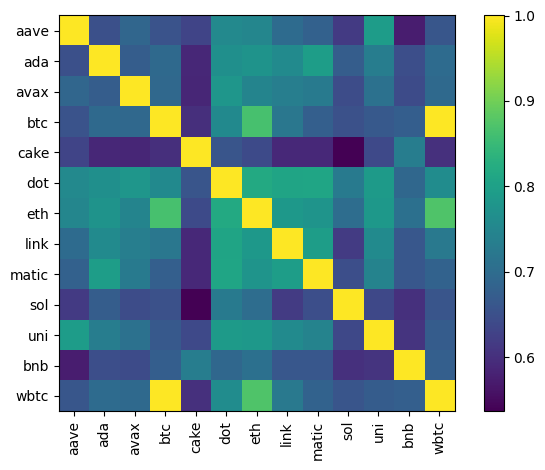

In [3]:
past_df, future_df = df.iloc[:-250], df.iloc[-250:]
future_cov = risk_models.sample_cov(future_df)

sample_cov = risk_models.sample_cov(past_df)
plotting.plot_covariance(sample_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

In [4]:
rets = expected_returns(df)
rets.tail()

,aave,ada,avax,btc,cake,dot,eth,link,matic,sol,uni,bnb,wbtc
date,,,,,,,,,,,,,
2023-07-16,-0.026166,-0.008205,0.014730,-0.000653,-0.007426,-0.003540,-0.002284,-0.002753,-0.012299,0.026051,-0.008906,0.013656,-0.000554
2023-07-17,-0.026923,-0.033928,-0.036122,-0.001357,-0.022958,-0.021628,-0.003196,-0.043356,-0.036932,-0.000939,-0.012907,-0.032328,-0.001066
2023-07-18,-0.021101,-0.007530,0.009329,-0.003505,0.028434,-0.001936,-0.006370,0.089304,0.012690,-0.018232,0.034099,0.004686,-0.003804
2023-07-19,-0.042012,-0.018456,-0.044670,-0.010218,-0.025269,-0.022891,-0.007785,-0.039419,-0.053164,-0.050761,-0.004085,-0.016682,-0.009499
2023-07-20,-0.003851,0.053785,0.016517,0.002590,0.004108,0.003642,-0.004155,-0.001351,0.010089,0.034707,-0.002700,0.004531,0.001821


In [5]:
# exp_cov = risk_models.exp_cov(past_df)
# plotting.plot_covariance(exp_cov, plot_correlation=True)
# plotting.plot_covariance(future_cov, plot_correlation=True)
# plt.show()

HRP Optimization
================

In [6]:
from portfolio_optimization.optimization.hrp import HRPOptimization

hrp = HRPOptimization(df, rets=rets)
hrp_weights = hrp.get_weights()
hrp_weights

aave     0.04387
ada      0.06603
avax     0.04737
btc      0.11021
cake     0.13496
dot      0.06525
eth      0.06833
link     0.09443
matic    0.06704
sol      0.03006
uni      0.04766
bnb      0.11421
wbtc     0.11059
dtype: float64

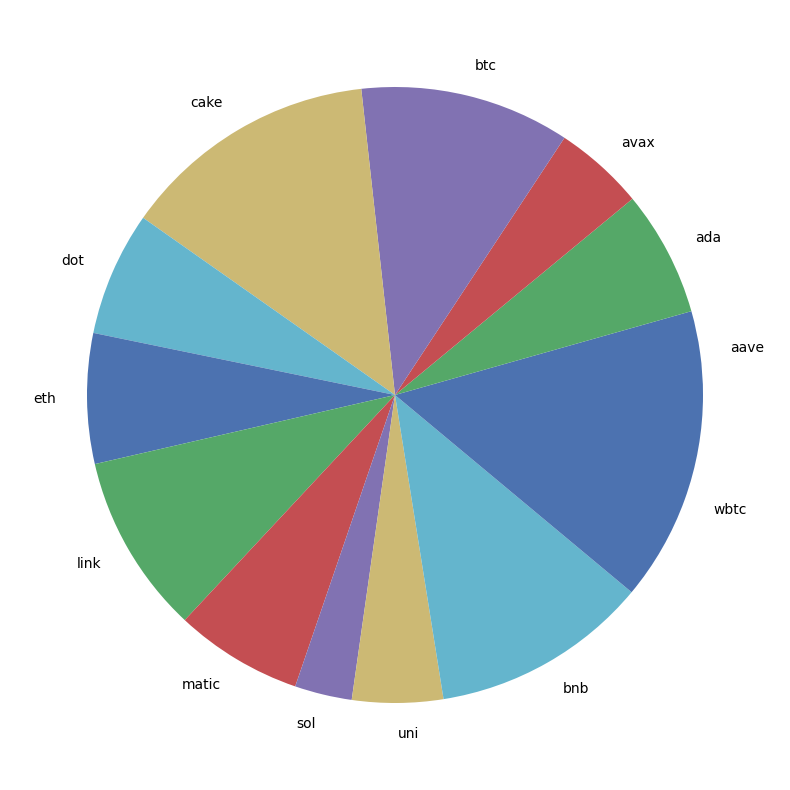

In [7]:
pd.Series(hrp_weights).plot.pie(figsize=(10, 10));

In [8]:
hrp.get_metrics()

{'apy': 0.030518251163052165,
 'annual_volatility': 0.4968333046624937,
 'sharpe_ratio': 0.02117058390479151}

# Markowitz optimization

/Users/arguiot/Developer/Pyratz/portfolio/portfolio_optimization/optimization/markowitz.py:124: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


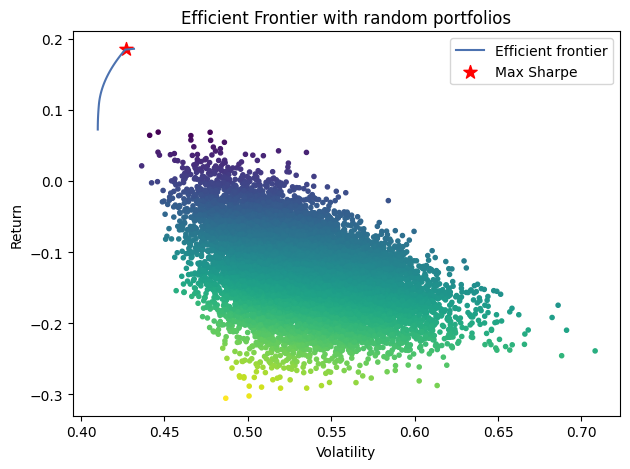

In [9]:
from portfolio_optimization.optimization.markowitz import Markowitz

markowitz = Markowitz(df, weight_bounds=(0, 1))

markowitz_weights = markowitz.get_weights()
markowitz.plot_frontier()

aave     0.00000
ada      0.00000
avax     0.00000
btc      0.53559
cake     0.00000
dot      0.00000
eth      0.00000
link     0.00000
matic    0.00000
sol      0.00000
uni      0.00000
bnb      0.00000
wbtc     0.46441
dtype: float64


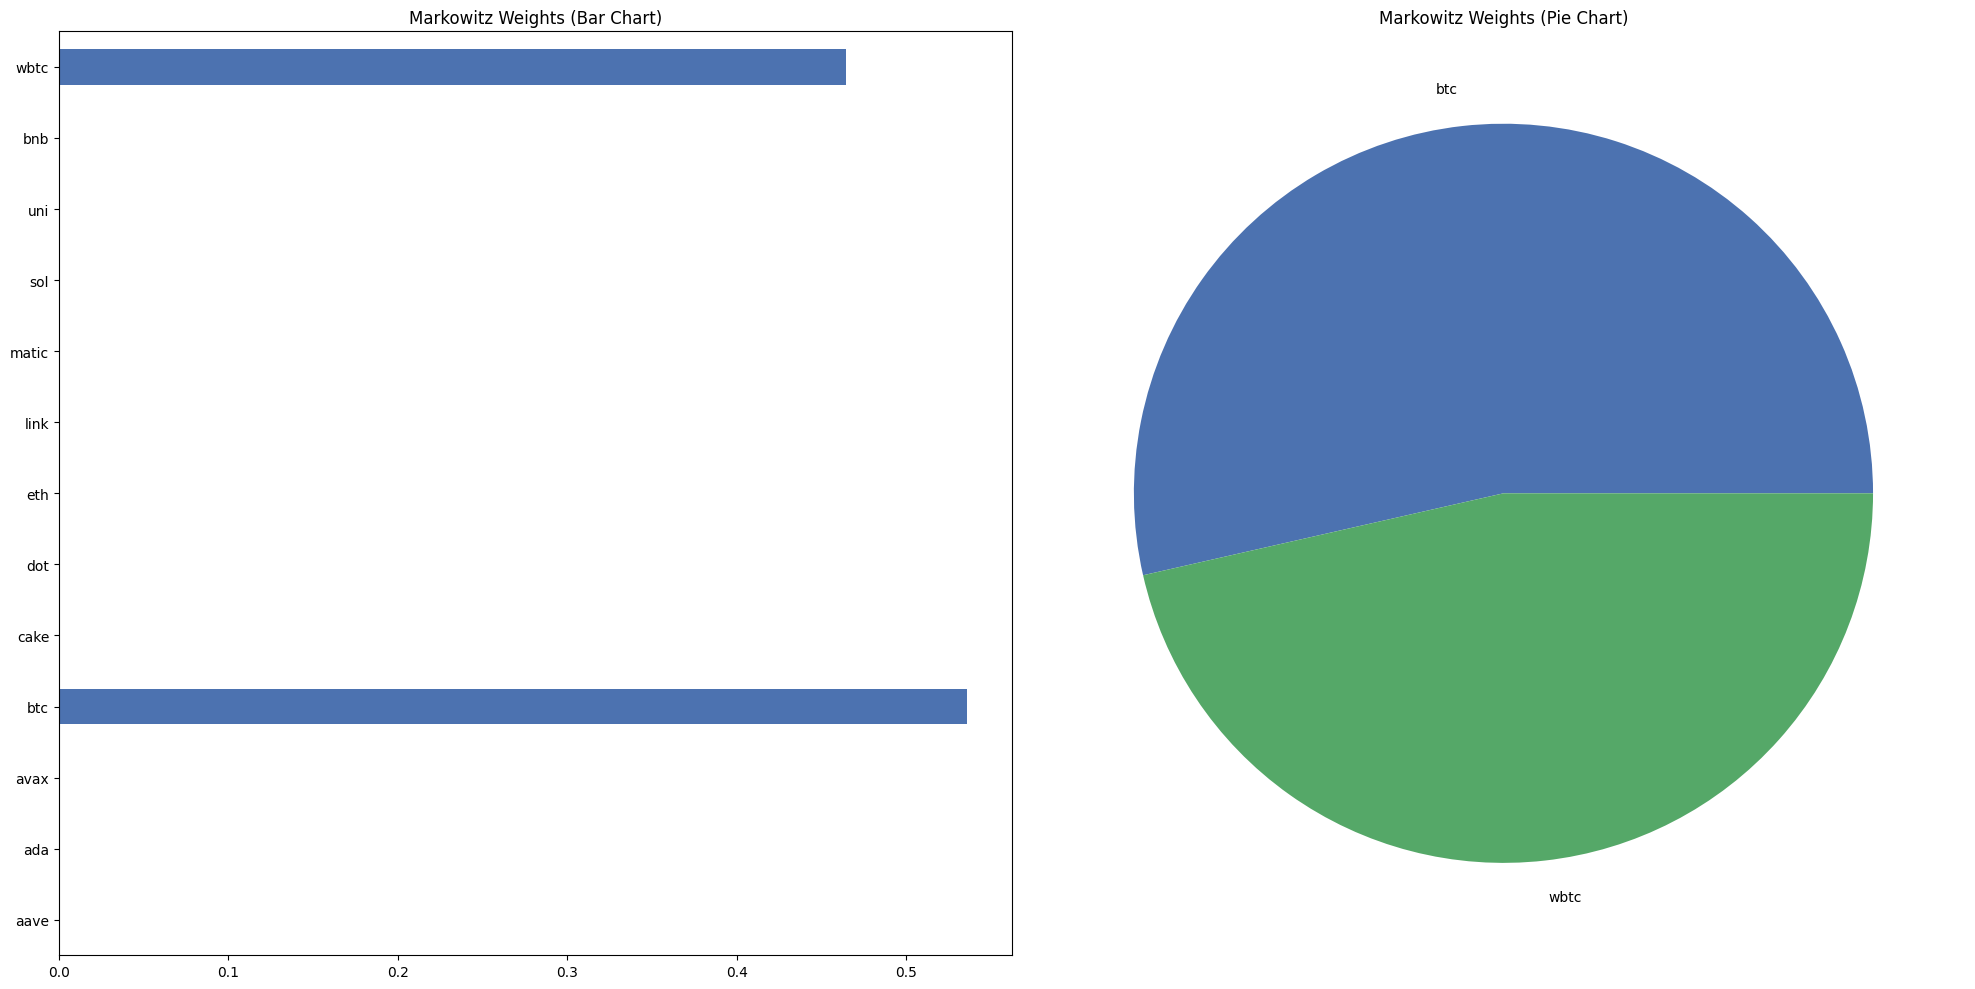

btc     0.53559
wbtc    0.46441
dtype: float64

In [10]:
print(markowitz_weights)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Bar chart on the left
pd.Series(markowitz_weights).plot(kind='barh', ax=axes[0], title="Markowitz Weights (Bar Chart)")

# Pie chart on the right without negative values
pd_weights = pd.Series(markowitz_weights)
positive_weights = pd_weights[pd_weights > 0]
positive_weights.plot(kind='pie', ax=axes[1], title="Markowitz Weights (Pie Chart)")

plt.tight_layout()
plt.show()
positive_weights

In [11]:
markowitz.get_metrics()

{'apy': 0.18526680243330623,
 'annual_volatility': 0.4267575343447654,
 'sharpe_ratio': 0.3872615926677275}

In [12]:
from portfolio_optimization.portfolio import weight_diff

diffs = weight_diff(markowitz_weights, hrp_weights, threshold=0.05)
print(len(diffs))
diffs

5


[('wbtc', 'Sell', 0.22703909754172524),
 ('btc', 'Sell', 0.2729576940599714),
 ('cake', 'Buy', 0.0866010870053452),
 ('bnb', 'Buy', 0.07328623404623945),
 ('link', 'Buy', 0.06059381035799309)]

In [13]:
from portfolio_optimization.portfolio.Portfolio import Portfolio
from portfolio_optimization.backtesting.Backtesting import Backtest

portfolio = Portfolio(
    weights=markowitz_weights,
    base_value=1000,
    initial_prices=df.iloc[155],
    optimiser=Markowitz,
)

from dateutil.relativedelta import relativedelta

start_date_portfolio = df.index[0] + relativedelta(months=5)
backtest = Backtest(
    portfolio=portfolio,
    start_date=start_date_portfolio,
    end_date=df.index[-1],
    rebalance_frequency="M",
    data=df,
)


portfolio_value, rebalance_dates, portfolio_compositions = backtest.run_backtest(look_back_period=5)
portfolio_value = portfolio_value.dropna()

at least one of the assets must have an expected return exceeding the risk-free rate
Skipping rebalance on 2022-12-31 due to insufficient data.


In [14]:
# from dash import Dash, html, dcc, Input, Output, callback
# import pandas as pd
# import plotly.express as px
# import plotly.graph_objects as go

# app = Dash(__name__)

# app.layout = html.Div([
#     html.Div([
#         dcc.Graph(id='portfolio-value-graph')
#     ], style={'display': 'inline-block', 'width': '49%'}),

#     html.Div([
#         dcc.Graph(id='pie-chart-display'),
#     ], style={'display': 'inline-block', 'width': '49%'})
# ])


# @app.callback(
#     Output('portfolio-value-graph', 'figure'),
#     Output('portfolio-value-graph', 'hoverData'),
#     Input('portfolio-value-graph', 'hoverData')
# )
# def update_portfolio_value_graph(hoverData):
#     figure = go.Figure(
#         data=go.Scatter(
#             x=portfolio_value.index, 
#             y=portfolio_value['Portfolio Value'], 
#             name='Portfolio Value',
#             mode='lines+markers'
#         )
#     )

#     # Update first hoverData to the earliest date in portfolio_value (or any default you want)
#     if hoverData is None:
#         hoverData = {'points': [{'x': portfolio_value.index[0]}]}
    
#     return figure, hoverData


# @app.callback(
#     Output('pie-chart-display', 'figure'),
#     Input('portfolio-value-graph', 'hoverData')
# )
# def update_pie_chart(hoverData=None):
#     if hoverData:
#         hoverDate = pd.Timestamp(hoverData['points'][0]['x'])  # Change here
#     else:
#         hoverDate = portfolio_value.index[0]

#     nearest_date = portfolio_compositions.index.asof(hoverDate)  # Find nearest date in portfolio_compositions

#     if pd.isnull(nearest_date):
#         nearest_date = portfolio_compositions.index[0]
        
#     vals = portfolio_compositions.loc[nearest_date]

#     figure = go.Figure(
#         data=go.Pie(
#             labels=list(vals.keys()), 
#             values=list(vals.values()), 
#             name=str(nearest_date.date()),  # Convert timestamp back to date for display
#             hoverinfo='label+percent'
#         )
#     )

#     return figure



# if __name__ == '__main__':
#     app.run_server(debug=True)

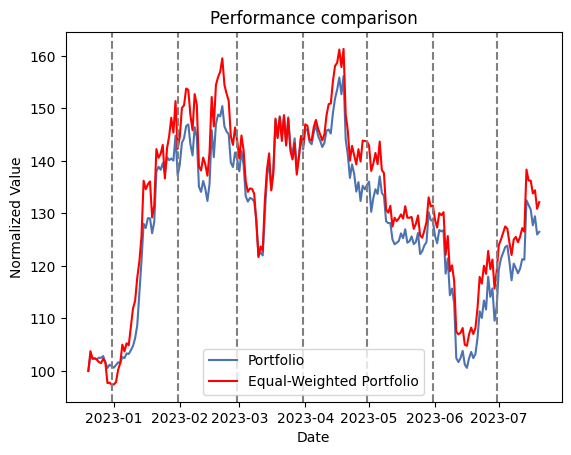

In [19]:
# Calculate the first date of the portfolio
start_date_portfolio = portfolio_value['Portfolio Value'].index.min()

# Normalize prices of each asset at the start date of the portfolio
df_normalized = df / df.loc[start_date_portfolio]

# Calculate the daily equal-weighted return  
df['equal_weighted'] = df_normalized.mean(axis=1)

# Normalize our portfolio and equally-weighted series to 100 at the start date of the portfolio
portfolio_normalized = 100 * portfolio_value['Portfolio Value'] / portfolio_value['Portfolio Value'].loc[start_date_portfolio]
equal_weighted_normalized = 100 * df['equal_weighted'] / df['equal_weighted'].loc[start_date_portfolio]

# Only consider the series after the portfolio start date
equal_weighted_normalized = equal_weighted_normalized[equal_weighted_normalized.index >= start_date_portfolio]
portfolio_normalized = portfolio_normalized[portfolio_normalized.index >= start_date_portfolio]

fig, ax = plt.subplots()

# Plot our normalized portfolio value
ax.plot(portfolio_normalized.index, portfolio_normalized, label='Portfolio')

# Plot the normalized equal-weighted portfolio
ax.plot(equal_weighted_normalized.index, equal_weighted_normalized, label='Equal-Weighted Portfolio', color='red')

# Visualize rebalance dates with vertical lines
for date in rebalance_dates:
    if date >= start_date_portfolio:
        ax.axvline(x=date, color='gray', linestyle='--')

ax.set_xlabel("Date")
ax.set_ylabel("Normalized Value")
ax.legend()
plt.title("Performance comparison")

plt.show()
